In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams["savefig.format"] = 'pdf'
sns.set(font_scale=1.5, rc={'text.usetex' : True})
sns.set_style("white")
sns.set_style("ticks")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [2]:
def validate_date(date_text):
    try:
        datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")
def extract_dataset(infected_cases, deceased_cases, date, simulation_time):        
    validate_date(date)
    d0 = datetime.strptime("2020-03-06", "%Y-%m-%d")
    d1 = datetime.strptime(date, "%Y-%m-%d")
    day_index = abs((d1-d0)).days
        
    if not infected_cases.size == deceased_cases.size:
        raise IndexError("The total decease cases data and the total infected cases data does not match in size. Please re-check the data")
        
    data = np.empty((round(simulation_time), 2))
    data[:, 0] = infected_cases[day_index+1:(day_index + round(simulation_time)+1):1]
    data[:, 1] = deceased_cases[day_index+1:(day_index + round(simulation_time)+1):1]
    return data

In [3]:
data_path = '../../Data/covid_7July2020/'
infected_total_state = np.loadtxt(data_path + 'infected_total_state.txt')
deceased_state = np.loadtxt(data_path + 'deceased_state.txt')

In [4]:
simulation_time = 35
date = "2020-06-01"
data = extract_dataset(infected_total_state, deceased_state, date, simulation_time)
print(data.shape)

(35, 2)


In [5]:
data[30]

array([175977.,   2525.])

In [6]:
fwd_path = '../../Model/seird/'

In [7]:
post_v = np.load('validation_posterior_samples.npy')
post_c = np.load('../calibration_results/calibration_posterior_samples.npy')

In [8]:
qoi_v = np.load('validation_posterior_qoi.npy')
qoi_c = np.load('validation_qoi_calibration_posterior_samples/qoi.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'validation_posterior_qoi.npy'

In [21]:
x_v = np.sort(qoi_v[:,29,1])
n_v = x_v.size
y_v = np.arange(1, n_v+1) / n_v
x_c = np.sort(qoi_c[:,29,1])
n_c = x_c.size
y_c = np.arange(1, n_c+1) / n_c

Text(0, 0.5, 'Total Infected Cases')

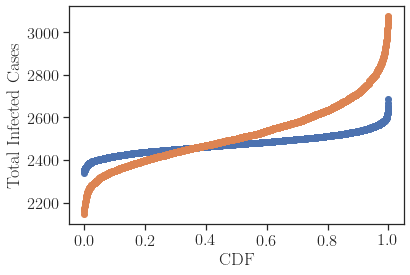

In [22]:
plt.scatter(x=y_v, y=x_v, label = r"calibration")
plt.scatter(x=y_c, y=x_c, label = r"validation")
plt.xlabel('CDF')
plt.ylabel('Total Infected Cases')

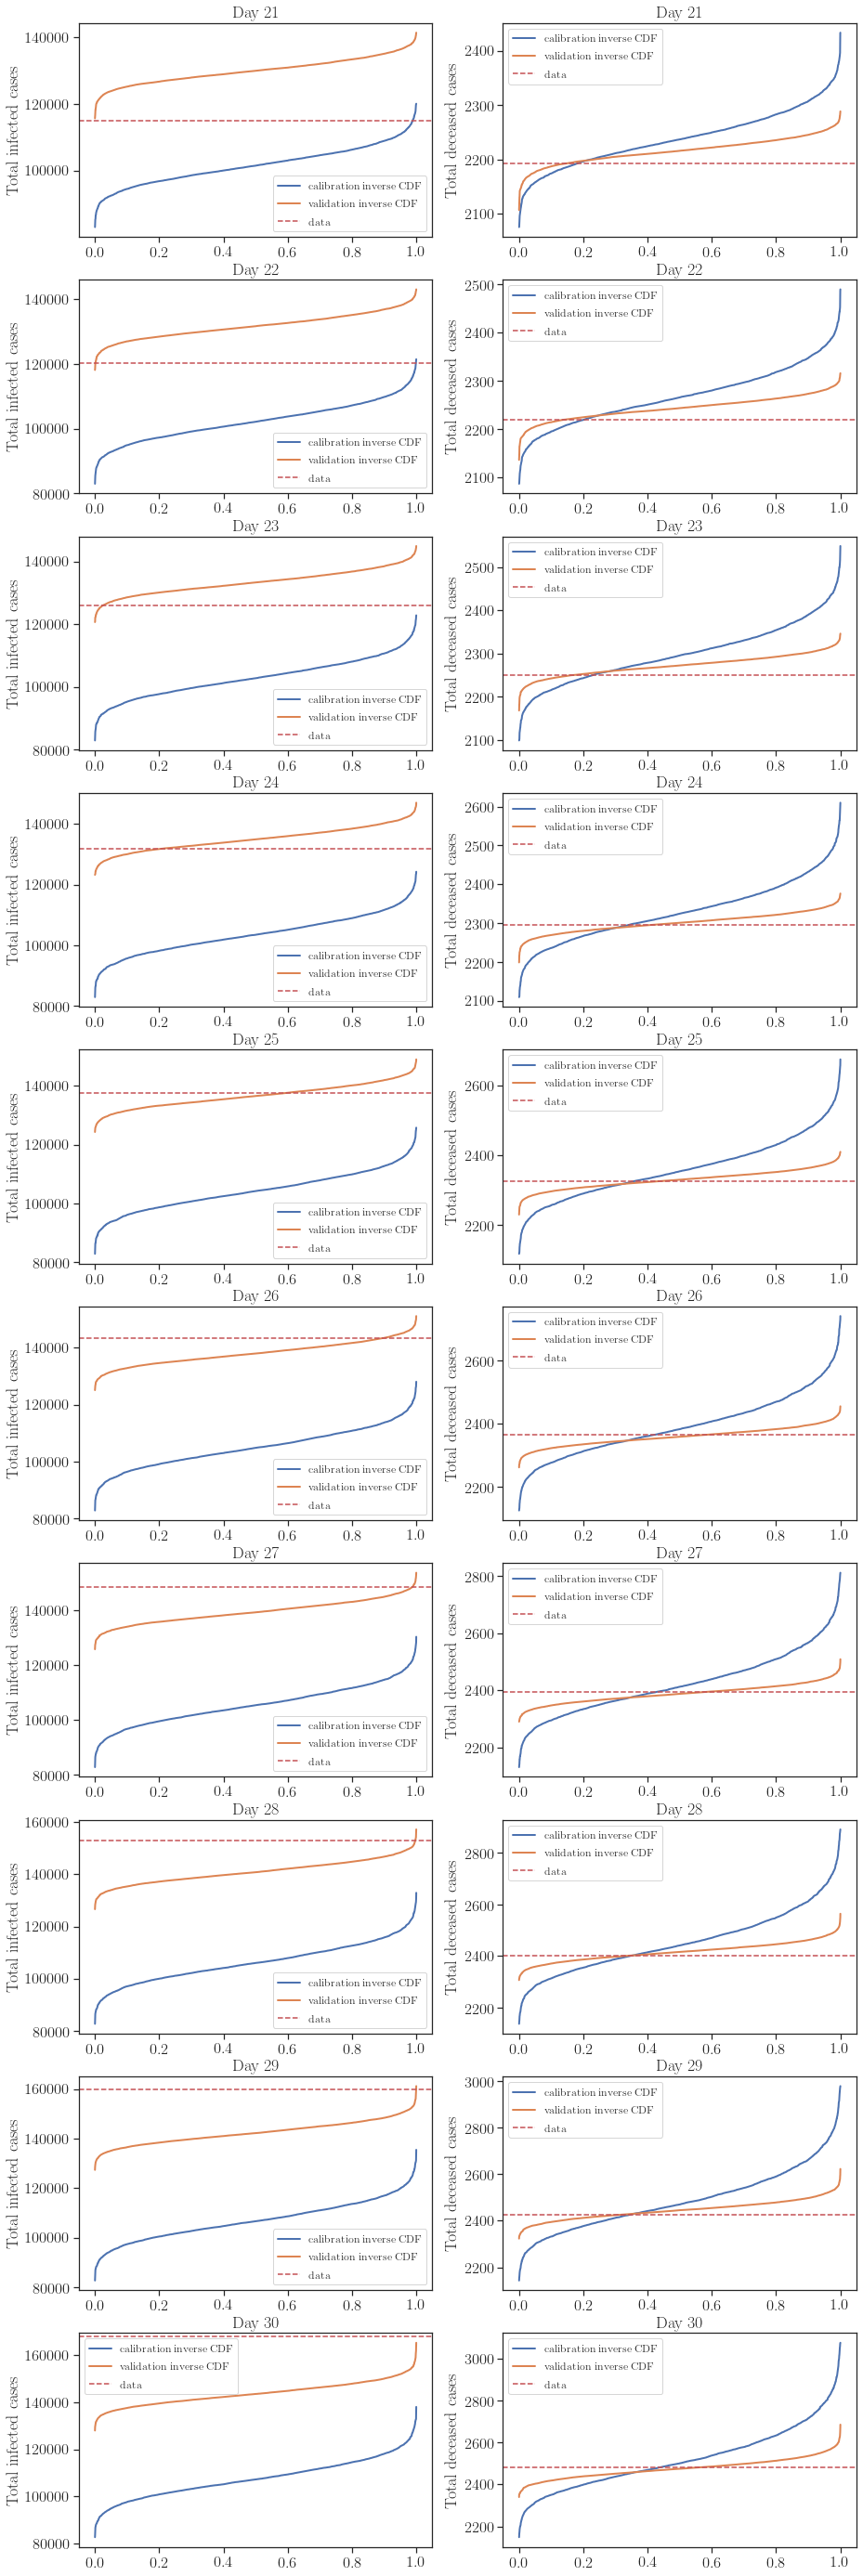

In [41]:
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(15,10*5))
for row in range(10):
    x_v = np.sort(qoi_v[:,20+row,0])
    n_v = x_v.size
    y_v = np.arange(1, n_v+1) / n_v
    x_c = np.sort(qoi_c[:,20+row,0])
    n_c = x_c.size
    y_c = np.arange(1, n_c+1) / n_c
    axs[row, 0].plot(y_c, x_c, label = r'calibration inverse CDF', linewidth = 2.)
    axs[row, 0].plot(y_v,x_v, label = 'validation inverse CDF', linewidth = 2. )
    axs[row, 0].axhline(y = data[20+row, 0], color='r', linestyle='--', label = r'data')
    axs[row, 0].set_title(r"Day " + str(21+row))
    axs[row, 0].set_ylabel(r'Total infected cases')
    axs[row, 0].legend(fontsize = 12, fancybox=True)
    
    x_v = np.sort(qoi_v[:,20+row,1])
    n_v = x_v.size
    y_v = np.arange(1, n_v+1) / n_v
    x_c = np.sort(qoi_c[:,20+row,1])
    n_c = x_c.size
    y_c = np.arange(1, n_c+1) / n_c
    axs[row, 1].plot(y_c, x_c, label = 'calibration inverse CDF', linewidth = 2.)
    axs[row, 1].plot(y_v,x_v, label = 'validation inverse CDF', linewidth = 2.)
    axs[row, 1].axhline(y = data[20+row, 1], color='r', linestyle='--', label = r'data')
    axs[row, 1].set_title(r"Day " + str(21+row))
    axs[row, 1].set_ylabel(r'Total deceased cases')
    axs[row, 1].legend(fontsize = 12, fancybox=True)

plt.savefig("calibration_vs_validation_inv_cdf.pdf",bbox_inches = "tight")

In [88]:
from scipy.interpolate import interp1d
f_c = [None]*10
f_v = [None]*10
for i in range (10):
    f_c[i] = [None]*2
    f_v[i] = [None]*2
    for j in range (2):
        x_v = np.sort(qoi_v[:,20+i,j])
        n_v = x_v.size
        y_v = np.arange(1, n_v+1) / n_v
        x_c = np.sort(qoi_c[:,20+i,j])
        n_c = x_c.size
        y_c = np.arange(1, n_c+1) / n_c
        f_c[i][j] = interp1d(y_c, x_c, kind='cubic')
        f_v[i][j] = interp1d(y_v, x_v, kind='cubic')

25.948838622813128
25.948838622813128


In [77]:
from scipy.optimize import minimize
max_loc = np.zeros((10,2))
cos = ({'type': 'ineq','fun' : lambda x: x-0.2}, {'type': 'ineq','fun' : lambda x: -x+0.8})
for i in range (10):
    for j in range (2):
        def func(x):
            return -abs(f_c[i][j](x)-f_v[i][j](x))
        res = minimize(func, 0.5, constraints=cos)
        max_loc[i,j] = res.x

In [78]:
print(max_loc)

[[0.20357909 0.79991085]
 [0.5000001  0.8       ]
 [0.50013536 0.49973667]
 [0.5002823  0.49966546]
 [0.2        0.80000001]
 [0.50122562 0.8       ]
 [0.50000215 0.79993314]
 [0.50002802 0.2       ]
 [0.50002518 0.8       ]
 [0.5008562  0.80000001]]


In [80]:
for i in range(10):
    for j in range(2):
        x = np.linspace(0.2,0.8, 10000)
        diff = abs(f_c[i][j](x)-f_v[i][j](x))

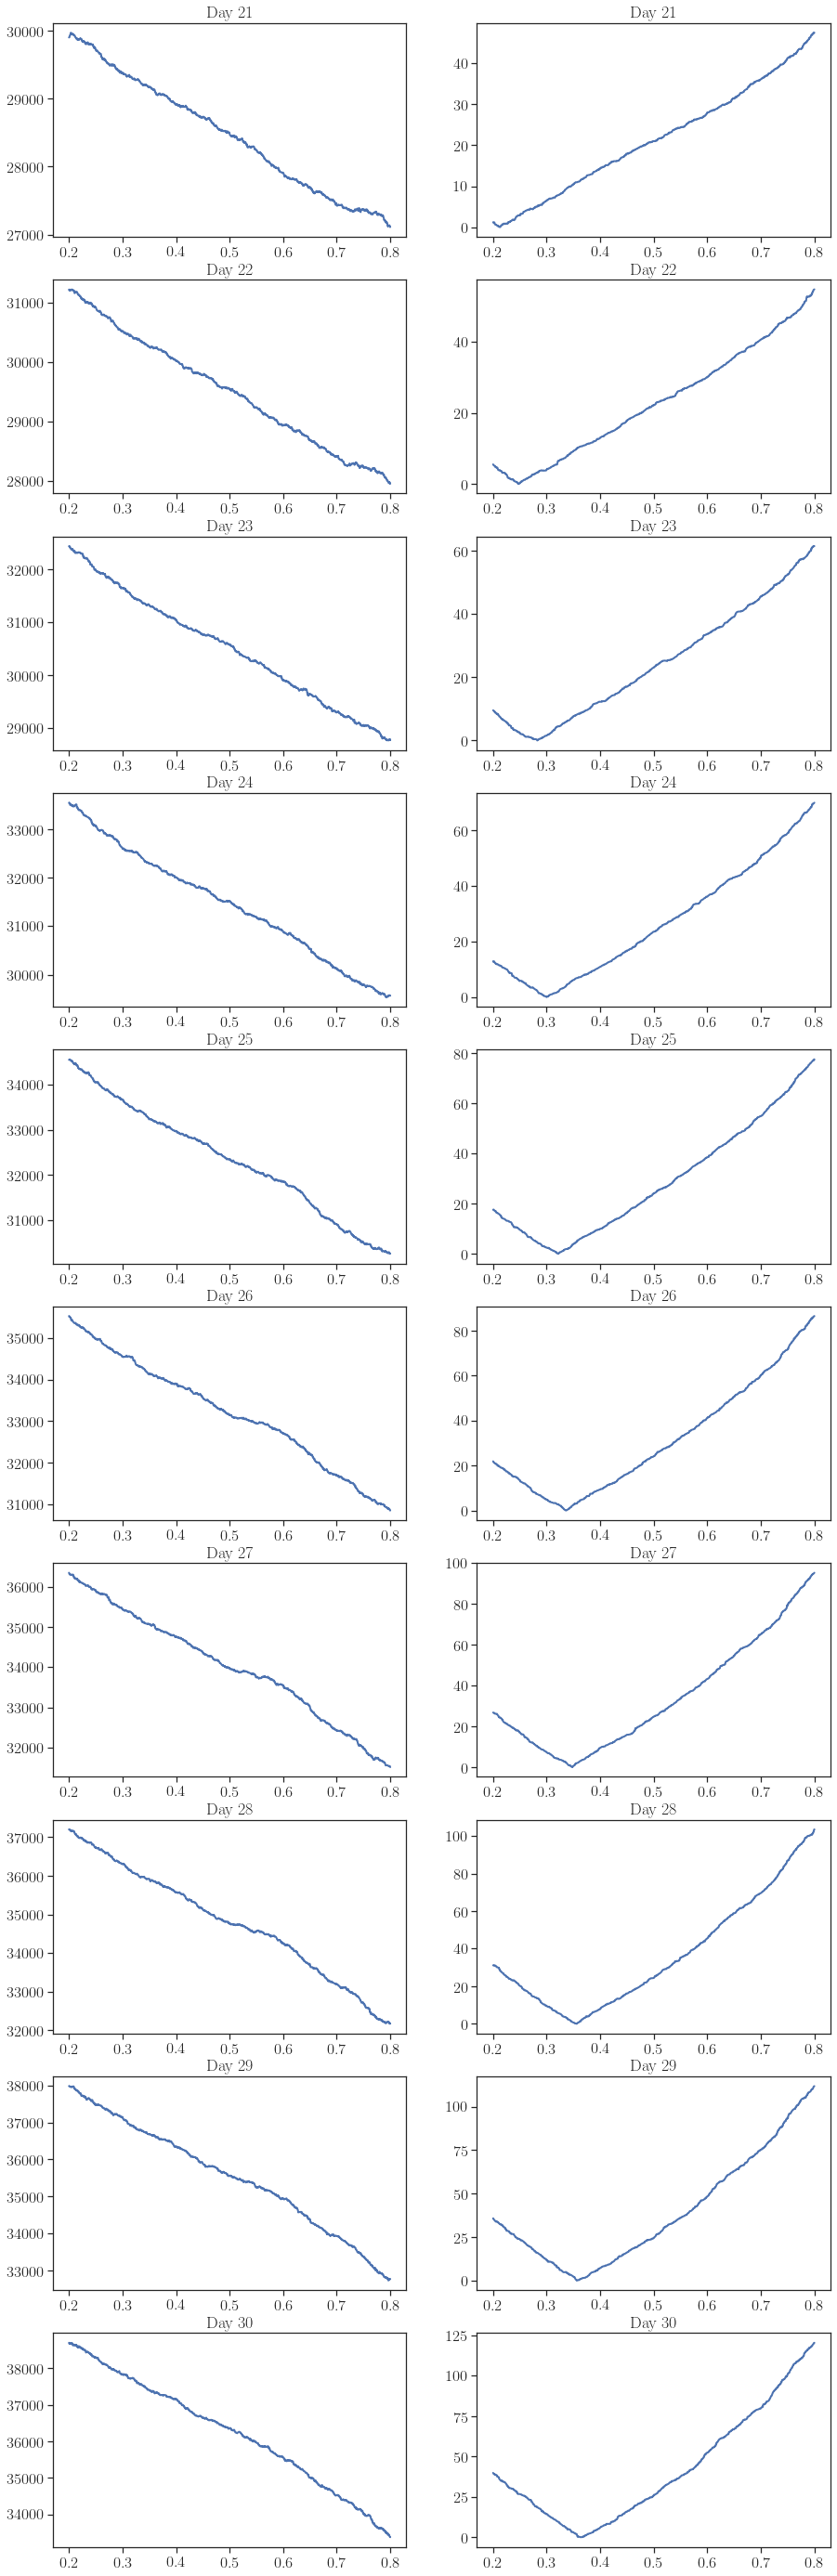

In [93]:
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(15,10*5))
x = np.linspace(0.2,0.8, 10000)
for row in range(10):
    axs[row, 0].plot(x, np.abs(f_c[row][0](x)-f_v[row][0](x)), linewidth = 2.)
    axs[row, 0].set_title(r"Day " + str(21+row))
    
    axs[row, 1].plot(x, np.abs(f_c[row][1](x)-f_v[row][1](x)), linewidth = 2.)
    axs[row, 1].set_title(r"Day " + str(21+row))

#plt.savefig("calibration_vs_validation_inv_cdf.pdf",bbox_inches = "tight")

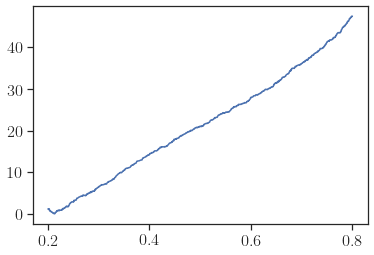

In [90]:
x = np.linspace(0.2,0.8, 10000)
y = abs(f_c[0][1](x)-f_v[0][1](x))
plt.plot(x,y)

In [94]:
M = np.zeros((10,2))

In [103]:
for i in range(10):
    M[i,0] = abs(f_c[i][0](0.2)-f_v[i][0](0.2))/np.mean(qoi_v[:,20+i,0])
    M[i,1] = abs(f_c[i][1](0.8)-f_v[i][1](0.8))/np.mean(qoi_v[:,20+i,1])

In [104]:
print(M)

[[0.23001528 0.02144857]
 [0.23694455 0.02445507]
 [0.24309733 0.02707904]
 [0.24840537 0.03035097]
 [0.25291178 0.03326075]
 [0.25724684 0.03666677]
 [0.26044119 0.0398959 ]
 [0.26387812 0.04283155]
 [0.26677656 0.04573797]
 [0.26922015 0.04868499]]


In [105]:
validation = np.mean(M, axis = 0)

In [106]:
print(validation)

[0.25289372 0.03504116]


In [108]:
import dolfin as dl
import hippylib as hl
mesh_path = '../FwdModelOnMap/data/mesh/'
mesh = dl.Mesh(mesh_path + "mesh_5h.xml")
Vh_PARAMETER = dl.VectorFunctionSpace(mesh, "R", degree=0, dim=7)
p_mean = np.mean(post_c, axis = 0)
p_cov = np.cov(post_c, rowvar = False)
mean = dl.Function(Vh_PARAMETER)
mean.vector().set_local(p_mean)
prior = hl.GaussianRealPrior(Vh_PARAMETER, p_cov, mean=mean.vector())

In [109]:
noise = dl.Vector()
prior.init_vector(noise,"noise")
hl.parRandom.normal(1., noise)
m = dl.Vector()
prior.init_vector(m, 0)
n_samples = 1000000
prior_samples = np.empty((n_samples ,7))
for i in range(n_samples):
    hl.parRandom.normal(1., noise)
    prior.sample(noise,m)
    prior_samples[i,:] = m.get_local()

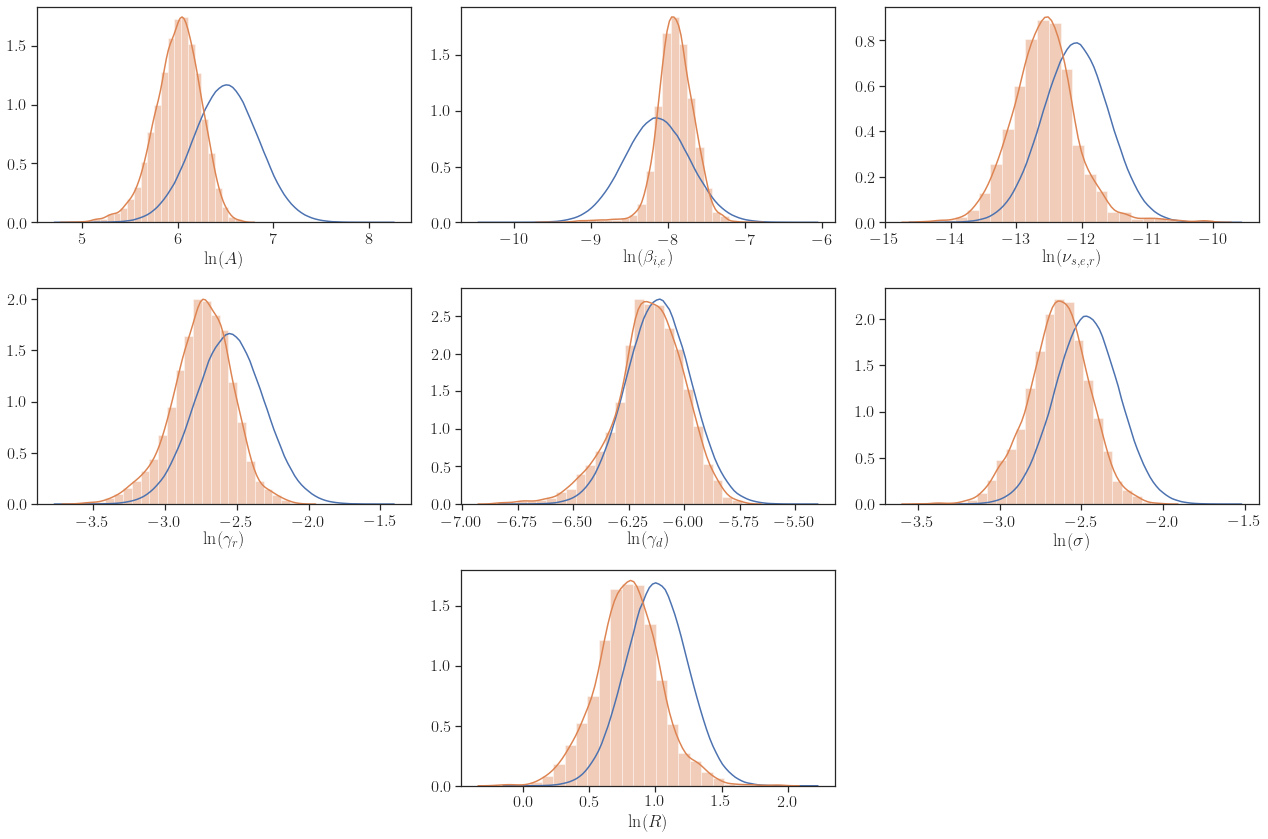

In [111]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize = (18,12))
titles = [r"$\ln(A)$", r"$\ln(\beta_{i,e})$", r"$\ln(\nu_{s,e,r})$", r"$\ln(\gamma_r)$", r"$\ln(\gamma_d)$", r"$\ln(\sigma)$",r"$\ln(R)$"]
idx = 0
for row in range(3):
    for col in range(3):
        if not row == 2 or col == 1:
            sns.distplot(prior_samples[:, idx], hist=False, ax=ax[row, col]);
            sns.distplot(post_v[:, idx], hist=True, bins = 25, ax=ax[row, col])
            ax[row,col].set_xlabel(titles[idx])
            idx += 1
        else:
            ax[row, col].axis('off')
fig.tight_layout()
plt.savefig("prior_vs_posterior_validation.pdf",bbox_inches = "tight")

In [114]:
inf_noise_var = 0.08
inf_upper = data[:,0]*(1+0.08)
inf_lower = data[:,0]*(1-0.08)
inf_noise_var = 0.04
dec_upper = data[:,1]*(1+0.05)
dec_lower = data[:,1]*(1-0.05)

In [120]:
print(qoi_v.shape)

(4530, 30, 2)


NameError: name 'qoi_v' is not defined

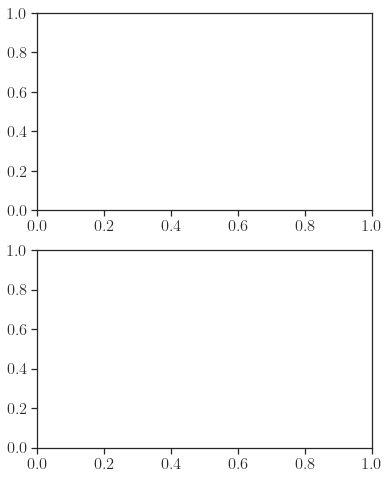

In [21]:
fig, ax = plt.subplots(2, figsize = (6,8))
for i in range(qoi_v.shape[0]):
    ax[0].plot(np.arange(10)+21, qoi_v[i,20:,0],'--', linewidth = 0.1)
ax[0].plot(np.arange(10)+21, data[20:, 0], "r-*", label = r'data')
ax[0].fill_between(np.arange(10)+21, inf_upper[20:], inf_lower[20:], alpha=0.2, edgecolor='r', facecolor='r')
ax[0].plot(np.arange(10)+21, validation_mean_qoi[20:, 0], "g-^", label = r'mean')
ax[0].legend(loc="upper left", fancybox=True)
ax[0].set_ylabel(r"Total infected cases")
for i in range(qoi_v.shape[0]):
    ax[1].plot(np.arange(10)+21, qoi_v[i,20:,1], '--',linewidth = 0.1)
ax[1].plot(np.arange(10)+21, data[20:, 1], "r-*",label = r'data')
ax[1].fill_between(np.arange(10)+21, dec_upper[20:], dec_lower[20:], alpha=0.2, edgecolor='r', facecolor='r')
ax[1].plot(np.arange(10)+21, validation_mean_qoi[20:, 1], "g-^", label = r'mean')
ax[1].legend(loc="upper left", fancybox=True)
ax[1].set_ylabel(r"Total decased cases")
ax[1].set_xlabel(r"Days")

plt.savefig("validation_qoi_with_noise.pdf",bbox_inches = "tight")

In [22]:
validation_mean_qoi = np.load('validation_mean_qoi.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'validation_mean_qoi.npy'

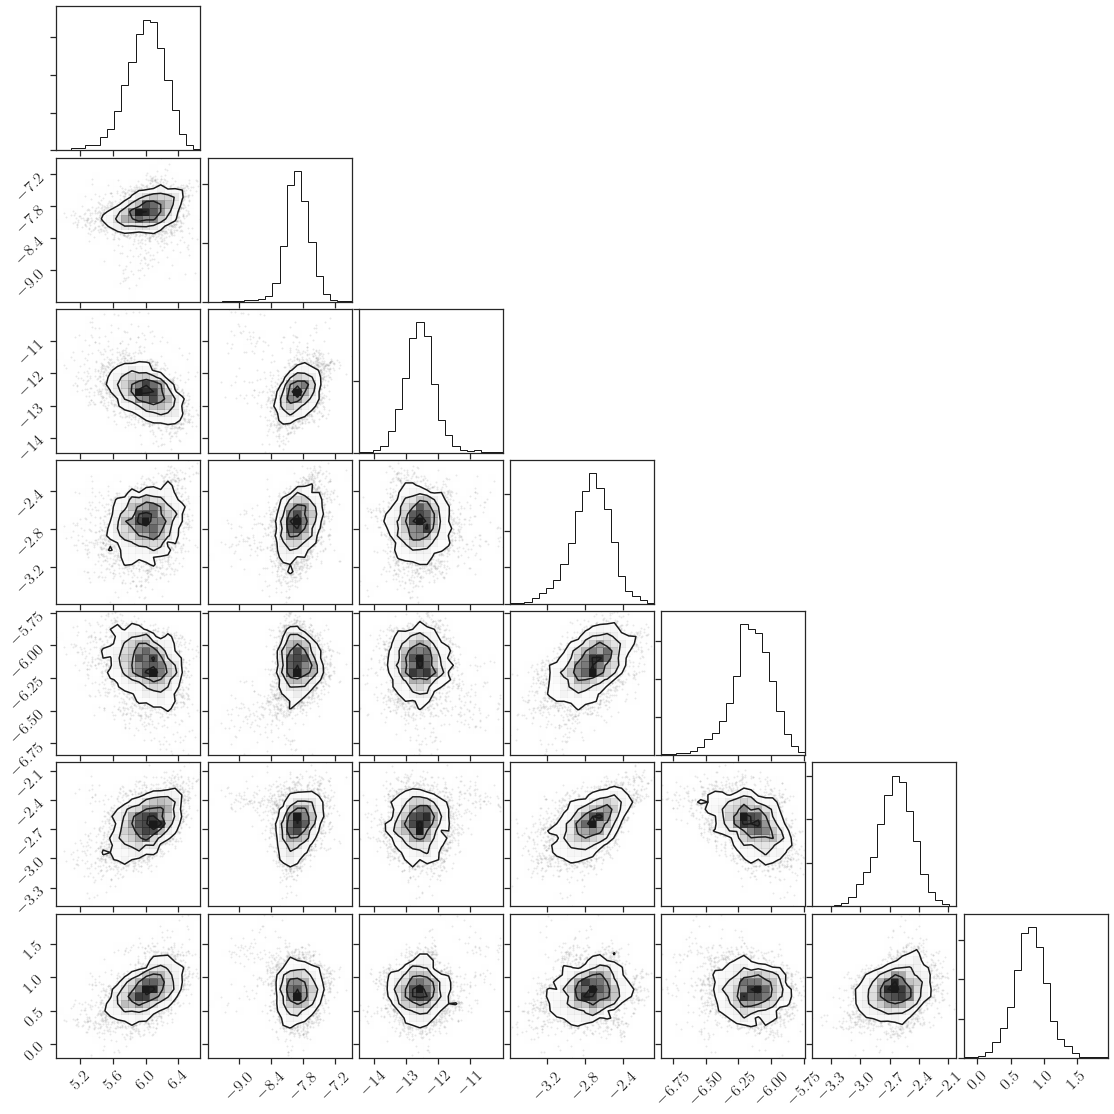

In [130]:
import corner

figure = corner.corner(post_v)

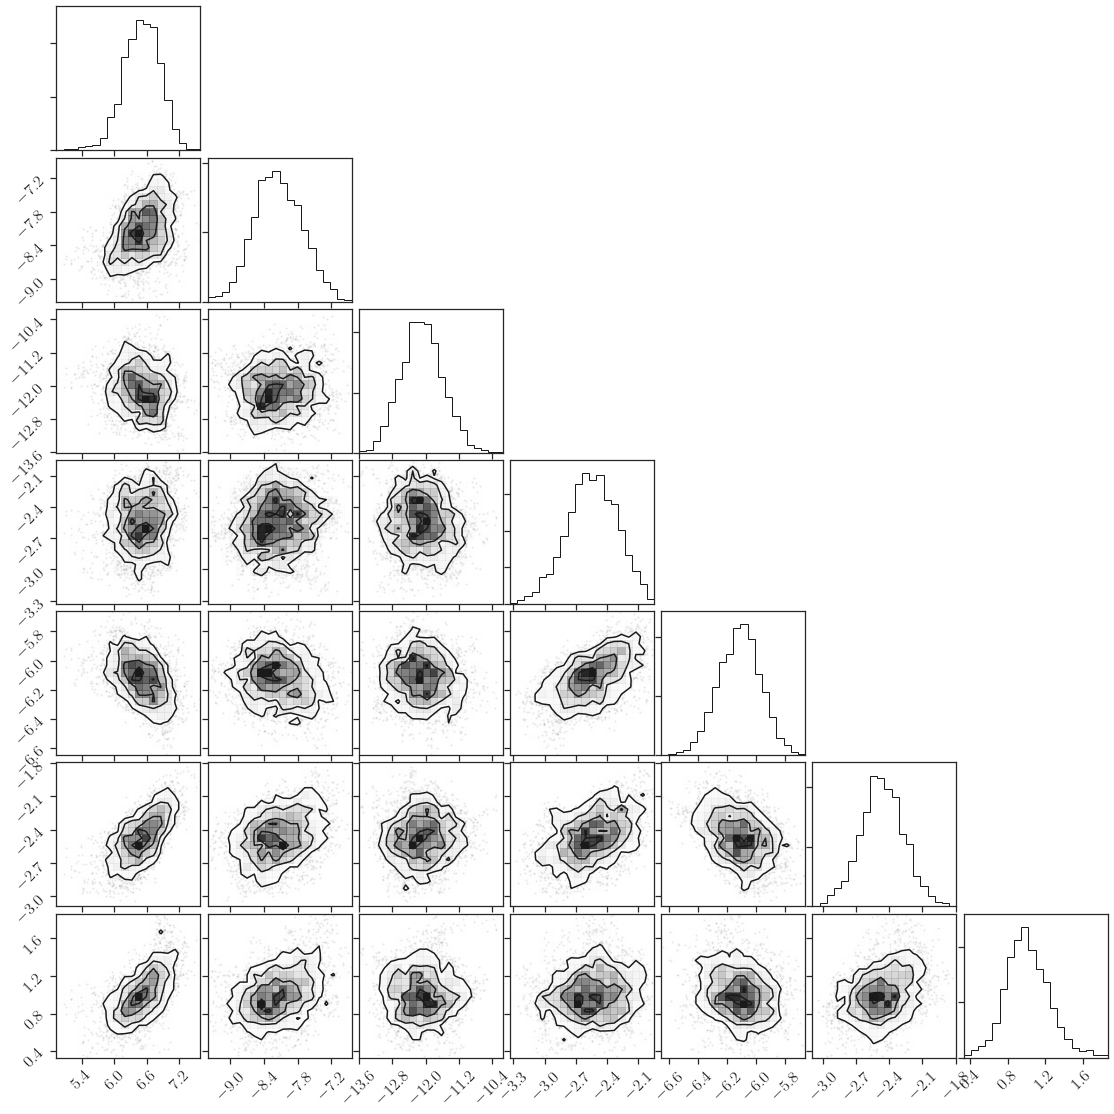

In [131]:
figure = corner.corner(post_c)

In [134]:
mean_v = np.mean(post_v, axis = 0)

In [135]:
np.exp(mean_v)

array([4.01614734e+02, 3.67188203e-04, 3.47195022e-06, 6.43351342e-02,
       2.12130271e-03, 7.11583267e-02, 2.21492792e+00])

In [142]:
var_v = np.var(post_v, axis = 0)
print(var_v)

[0.05691936 0.05926898 0.25043382 0.04509787 0.02427923 0.03530215
 0.06176147]


In [140]:
mean = np.exp(mean_v + 0.5*var_v)

In [141]:
print(mean)

[4.13208759e+02 3.78232475e-04 3.93508849e-06 6.58023024e-02
 2.14721145e-03 7.24254982e-02 2.28439357e+00]


In [143]:
print(np.exp(mean_v-var_v))

[3.79393489e+02 3.46057709e-04 2.70278477e-06 6.14982069e-02
 2.07041932e-03 6.86901077e-02 2.08226948e+00]


In [148]:
mean_c = np.mean(post_c, axis = 0)
var_c = np.var(post_c, axis = 0)
print(var_c)
mean = np.exp(mean_c + 0.5*var_c)
print(mean)
print(np.exp(mean_c-var_c))
print(1./np.exp(mean_c-var_c))

[0.11631781 0.180599   0.2545646  0.05752581 0.02139718 0.03832245
 0.05518847]
[7.07326155e+02 3.16752775e-04 6.38513035e-06 8.04277926e-02
 2.23285186e-03 8.66063386e-02 2.82124249e+00]
[5.94080699e+02 2.41585411e-04 4.35848713e-06 7.37787743e-02
 2.16232463e-03 8.17682749e-02 2.59709802e+00]
[1.68327300e-03 4.13932280e+03 2.29437411e+05 1.35540338e+01
 4.62465250e+02 1.22296820e+01 3.85045151e-01]


In [149]:
np.save("calibration_posterior_mean.npy", mean)

In [150]:
print(post_v.shape)

(4530, 7)


In [4]:
validation_qoi_path = "../Results/Sensitivity/prediction_qoi_calibration_posterior_samples/qoi/"
for i in range(20):
    if i == 0:
        qoi_dist = np.load(validation_qoi_path + "qoi_" +str(i) + ".npy")
    else:
        qoi_dist = np.append(qoi_dist, np.load(validation_qoi_path + "qoi_" +str(i) + ".npy"), axis = 0)

In [5]:
qoi_dist.shape

(2940, 110, 26, 2)

NameError: name 'qoi_v' is not defined

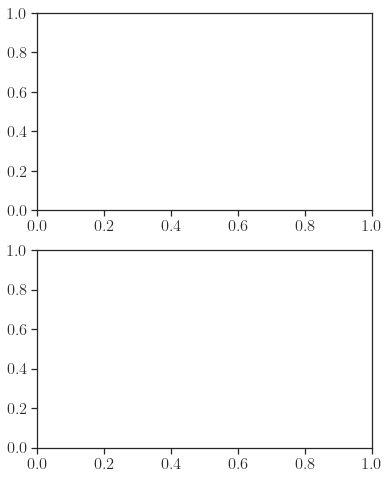

In [6]:
fig, ax = plt.subplots(2, figsize = (6,8))
for i in range(qoi_v.shape[0]):
    ax[0].plot(np.arange(10)+21, qoi_v[i,20:,0],'--', linewidth = 0.1)
ax[0].plot(np.arange(10)+21, data[20:, 0], "r-*", label = r'data')
ax[0].fill_between(np.arange(10)+21, inf_upper[20:], inf_lower[20:], alpha=0.2, edgecolor='r', facecolor='r')
ax[0].plot(np.arange(10)+21, validation_mean_qoi[20:, 0], "g-^", label = r'mean')
ax[0].legend(loc="upper left", fancybox=True)
ax[0].set_ylabel(r"Total infected cases")
for i in range(qoi_v.shape[0]):
    ax[1].plot(np.arange(10)+21, qoi_v[i,20:,1], '--',linewidth = 0.1)
ax[1].plot(np.arange(10)+21, data[20:, 1], "r-*",label = r'data')
ax[1].fill_between(np.arange(10)+21, dec_upper[20:], dec_lower[20:], alpha=0.2, edgecolor='r', facecolor='r')
ax[1].plot(np.arange(10)+21, validation_mean_qoi[20:, 1], "g-^", label = r'mean')
ax[1].legend(loc="upper left", fancybox=True)
ax[1].set_ylabel(r"Total decased cases")
ax[1].set_xlabel(r"Days")

# plt.savefig("validation_qoi_with_noise.pdf",bbox_inches = "tight")

In [7]:
data_path = '../FwdModelOnMap/data/covid_7July2020/'
infected_total_district = np.loadtxt(data_path + 'infected_total_district.txt')
deceased_district = np.loadtxt(data_path + 'deceased_district.txt')

In [8]:
infected_total_district.shape
deceased_district.shape

(124, 25)

In [23]:
def extract_district_dataset(infected_cases, deceased_cases, date, simulation_time):        
    validate_date(date)
    d0 = datetime.strptime("2020-03-06", "%Y-%m-%d")
    d1 = datetime.strptime(date, "%Y-%m-%d")
    day_index = abs((d1-d0)).days
        
    if not infected_cases.size == deceased_cases.size:
        raise IndexError("The total decease cases data and the total infected cases data does not match in size. Please re-check the data")
        
    data = np.empty((round(simulation_time), 25, 2))
    data[:, :, 0] = infected_cases[day_index+1:(day_index + round(simulation_time)+1):1, :]
    data[:, :, 1] = deceased_cases[day_index+1:(day_index + round(simulation_time)+1):1, :]
    return data

In [24]:
district_data = extract_district_dataset(infected_total_district, deceased_district, date, 30)

In [25]:
print(district_data.shape)

(30, 25, 2)


In [26]:
district_names = [r'Paris',r'Fort Worth',r'Wichita Falls', r'Amarillo', r'Lubbock', r'Odessa',\
                  r'San Angelo', r'Abilene', r'Waco', r'Tyler', r'Lufkin', r'Houston', r'Yoakum',\
                  r'Austin', r'San Antonio', r'Corpus Christi', r'Bryan', r'Dallas', r'Atlanta',\
                  r'Beaumont', r'Pharr', r'Laredo', r'Brownwood', r'El Paso', r'Childress']

ValueError: x and y must have same first dimension, but have shapes (10,) and (15,)

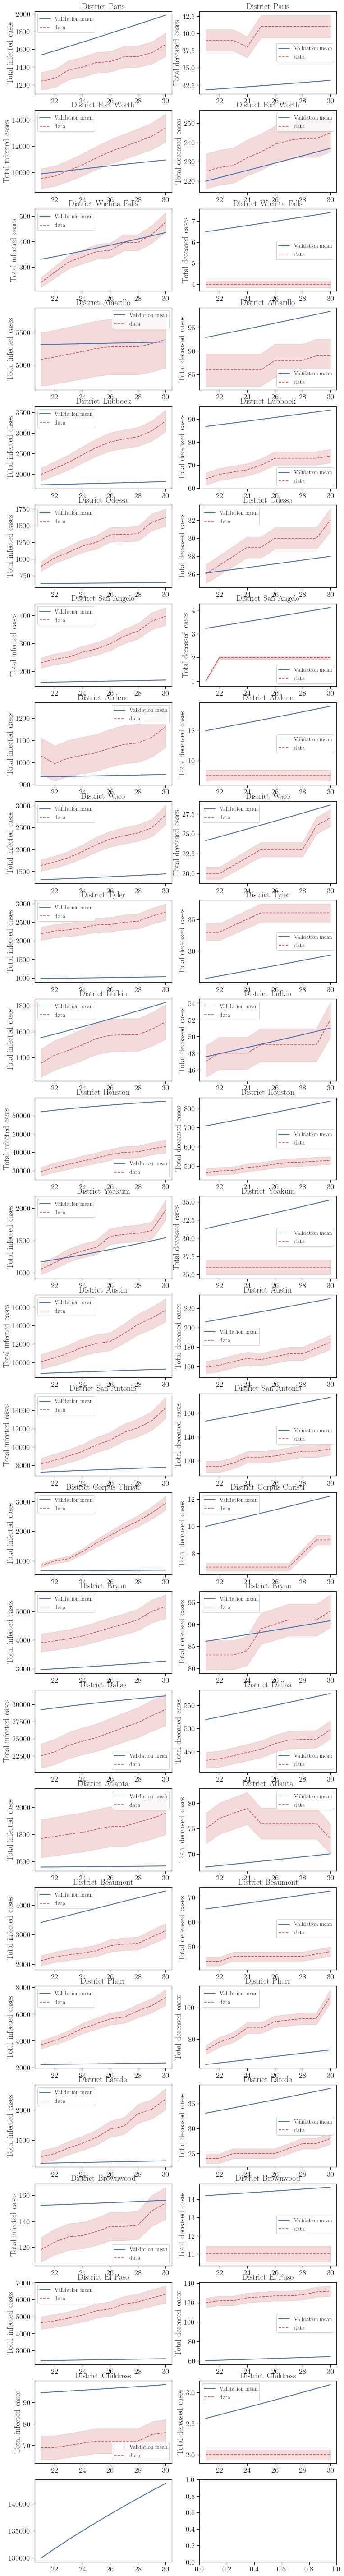

In [27]:
inf_upper = data[:,0]*(1+0.08)
inf_lower = data[:,0]*(1-0.08)
dec_upper = data[:,1]*(1+0.04)
dec_lower = data[:,1]*(1-0.04)
fig,axs = plt.subplots(nrows=26, ncols=2, figsize=(12,4*26))
for row in range(25):
    axs[row, 0].plot(np.arange(10)+21, np.mean(qoi_dist[:, 20:30, row, 0], axis = 0), label = r'Validation mean', linewidth = 2.)
    axs[row, 0].plot(np.arange(10)+21, district_data[20:, row, 0], color='r', linestyle='--', label = r'data')
    axs[row, 0].fill_between(np.arange(10)+21, district_data[20:, row, 0]*(1+0.08), district_data[20:, row, 0]*(1-0.08), alpha=0.2, edgecolor='r', facecolor='r')
    axs[row, 0].set_title(r"District " + district_names[row])
    axs[row, 0].set_ylabel(r'Total infected cases')
    axs[row, 0].legend(fontsize = 12, fancybox=True)
    axs[row, 1].plot(np.arange(10)+21, np.mean(qoi_dist[:, 20:30, row, 1], axis = 0), label = r'Validation mean', linewidth = 2.)
    axs[row, 1].plot(np.arange(10)+21, district_data[20:, row, 1], color='r', linestyle='--', label = r'data')
    axs[row, 1].fill_between(np.arange(10)+21, district_data[20:, row, 1]*(1+0.04), district_data[20:, row, 1]*(1-0.04), alpha=0.2, edgecolor='r', facecolor='r')
    axs[row, 1].set_title(r"District " + district_names[row])
    axs[row, 1].set_ylabel(r'Total deceased cases')
    axs[row, 1].legend(fontsize = 12, fancybox=True)

row = 25
axs[row, 0].plot(np.arange(10)+21, np.mean(qoi_dist[:, 20:30, row, 0], axis = 0), label = r'Validation mean', linewidth = 2.)
axs[row, 0].plot(np.arange(10)+21, data[20:, 0], color='r', linestyle='--', label = r'data')
axs[row, 0].fill_between(np.arange(10)+21, data[20:, 0]*(1+0.08), data[20:, 0]*(1-0.08), alpha=0.2, edgecolor='r', facecolor='r')
axs[row, 0].set_title(r"Whole Texas")
axs[row, 0].set_ylabel(r'Total infected cases')
axs[row, 0].legend(fontsize = 12, fancybox=True)
axs[row, 1].plot(np.arange(10)+21, np.mean(qoi_dist[:, 20:30, row, 1], axis = 0), label = r'Validation mean', linewidth = 2.)
axs[row, 1].plot(np.arange(10)+21, data[20:, 1], color='r', linestyle='--', label = r'data')
axs[row, 1].fill_between(np.arange(10)+21, data[20:, 1]*(1+0.04), data[20:, 1]*(1-0.04), alpha=0.2, edgecolor='r', facecolor='r')
axs[row, 1].set_title(r"Whole Texas")
axs[row, 1].set_ylabel(r'Total deceased cases')
axs[row, 1].legend(fontsize = 12, fancybox=True)
fig.tight_layout()

ValueError: x and y must have same first dimension, but have shapes (15,) and (10,)

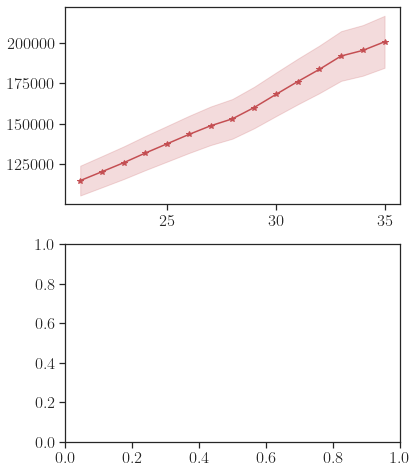

In [28]:
fig, ax = plt.subplots(2, figsize = (6,8))
ax[0].plot(np.arange(15)+21, data[20:, 0], "r-*", label = r'data')
ax[0].fill_between(np.arange(15)+21, data[20:, 0]*(1+0.08), data[20:, 0]*(1-0.08), alpha=0.2, edgecolor='r', facecolor='r')
ax[0].plot(np.arange(15)+21, np.mean(qoi_dist[:, 20:30, 25, 0], axis =0), "g-^", label = r'mean')
ax[0].legend(loc="upper left", fancybox=True)
ax[0].set_ylabel(r"Total infected cases")
ax[1].plot(np.arange(15)+21, data[20:, 1], "r-*",label = r'data')
ax[1].fill_between(np.arange(15)+21, data[20:, 1]*(1+0.04), data[20:, 1]*(1-0.04), alpha=0.2, edgecolor='r', facecolor='r')
ax[1].plot(np.arange(15)+21, np.mean(qoi_dist[:, 20:35, 25, 1], axis = 0), "g-^", label = r'mean')
ax[1].legend(loc="upper left", fancybox=True)
ax[1].set_ylabel(r"Total decased cases")
ax[1].set_xlabel(r"Days")

#plt.savefig("validation_qoi_with_noise.pdf",bbox_inches = "tight")

In [29]:
for i in range(10):
    misfit_infected = np.abs(np.mean(qoi_dist[:, 20:30, 25, 0],axis =0) - data[20:30, 0])
    misfit_deceased = np.abs(np.mean(qoi_dist[:, 20:30, 25, 1],axis =0) - data[20:30, 1])

In [30]:
print(misfit_infected/data[20:30, 0])
print(misfit_deceased/data[20:30, 1])

[0.13117378 0.0940916  0.05917934 0.02329032 0.00778728 0.03695494
 0.06173312 0.0786354  0.11002548 0.14460429]
[0.01014492 0.01018815 0.00987197 0.00174095 0.00215568 0.00327699
 0.00220862 0.00600135 0.00964252 0.00137895]


In [31]:
error_infected = np.sqrt(0.1*np.sum((misfit_infected/data[20:30, 0])**2))
error_deceased = np.sqrt(0.1*np.sum((misfit_deceased/data[20:30, 1])**2))

In [32]:
print(error_infected)
print(error_deceased)

0.08633726946778933
0.00677025698065053


In [33]:
import scipy.stats

def mean_confidence_interval(data):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h1 = se * scipy.stats.t.ppf((1 + 0.68) / 2., n-1)
    h2 = se * scipy.stats.t.ppf((1 + 0.95) / 2., n-1)
    return np.array([m, h1, h2])

In [34]:
total_qoi_evolution = np.zeros((110, 26, 3, 2))
for i in range (110):
    for j in range (26):
        for k in range (2):
            total_qoi_evolution[i,j,:,k] = mean_confidence_interval(qoi_dist[:, i, j, k])

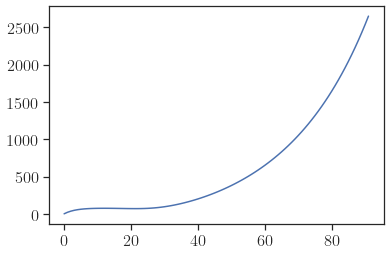

In [35]:
plt.plot(total_qoi_evolution[0:92, -1, 1, 0])

In [39]:
a = total_qoi_evolution[-1, -1, :, 0]
print('Infencted mean: {0:<5} sigma: {1:<5} CI: ({2}, {3})'.format(a[0], a[1], a[0] - a[2], a[0] + a[2]))

Infencted mean: 301658.0406510673 sigma: 5786.240722841652 CI: (290251.2465696581, 313064.83473247645)


In [40]:
a = total_qoi_evolution[-1, -1, :, 1]
print('Deceased mean: {0:<5} sigma: {1:<5} CI: ({2}, {3})'.format(a[0], a[1], a[0] - a[2], a[0] + a[2]))

Deceased mean: 7002.807252085806 sigma: 101.87207658658414 CI: (6801.980176972686, 7203.634327198925)


In [203]:
import os
os.mkdir("../Results/prediction_results")
np.save("../Results/prediction_results/prediction_results_mean_ci.npy", total_qoi_evolution)

/Users/prashant/opt/anaconda3/envs/confen/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


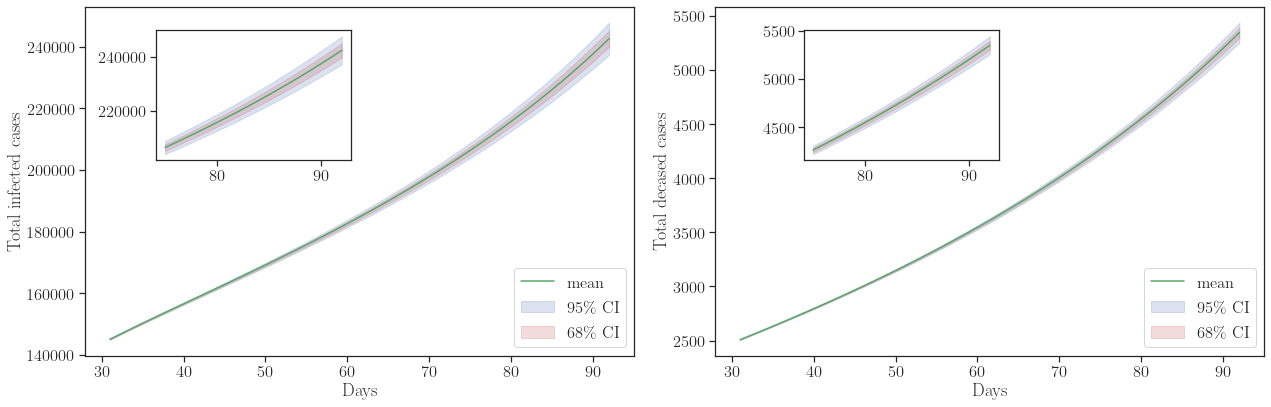

In [42]:
fig, ax = plt.subplots(ncols = 2, figsize = (18,6))
for col in range (2):
    ax[col].fill_between(np.arange(92-30)+31, total_qoi_evolution[30:92, -1, 0, col] + total_qoi_evolution[30:92, -1, 2, col],\
                         total_qoi_evolution[30:92, -1, 0, col] - total_qoi_evolution[30:92, -1, 2, col],\
                         alpha=0.2, edgecolor='b', facecolor='b', label = r'$95\%$ CI')
    ax[col].fill_between(np.arange(92-30)+31, total_qoi_evolution[30:92, -1, 0, col] + total_qoi_evolution[30:92, -1, 1, col],\
                         total_qoi_evolution[30:92, -1, 0, col] - total_qoi_evolution[30:92, -1, 1, col],\
                         alpha=0.2, edgecolor='r', facecolor='r', label = r'$68\%$ CI')
    ax[col].plot(np.arange(92-30)+31, total_qoi_evolution[30:92, -1, 0, col], "g-", label = r'mean')
    ax[col].legend(loc="lower right", fancybox=True)
    ax[col].set_xlabel(r"Days")
ax[0].set_ylabel(r"Total infected cases")
ax[1].set_ylabel(r"Total decased cases")


a = plt.axes([0.13, .6, .15, .3])
col = 0
plt.fill_between(np.arange(92-74)+75, total_qoi_evolution[74:92, -1, 0, col] + total_qoi_evolution[74:92, -1, 2, col],\
                         total_qoi_evolution[74:92, -1, 0, col] - total_qoi_evolution[74:92, -1, 2, col],\
                         alpha=0.2, edgecolor='b', facecolor='b')
plt.fill_between(np.arange(92-74)+75, total_qoi_evolution[74:92, -1, 0, col] + total_qoi_evolution[74:92, -1, 1, col],\
                         total_qoi_evolution[74:92, -1, 0, col] - total_qoi_evolution[74:92, -1, 1, col],\
                         alpha=0.2, edgecolor='r', facecolor='r')
plt.plot(np.arange(92-74)+75, total_qoi_evolution[74:92, -1, 0, col], "g-", label = r'mean')

a = plt.axes([0.63, .6, .15, .3])
col = 1
plt.fill_between(np.arange(92-74)+75, total_qoi_evolution[74:92, -1, 0, col] + total_qoi_evolution[74:92, -1, 2, col],\
                         total_qoi_evolution[74:92, -1, 0, col] - total_qoi_evolution[74:92, -1, 2, col],\
                         alpha=0.2, edgecolor='b', facecolor='b')
plt.fill_between(np.arange(92-74)+75, total_qoi_evolution[74:92, -1, 0, col] + total_qoi_evolution[74:92, -1, 1, col],\
                         total_qoi_evolution[74:92, -1, 0, col] - total_qoi_evolution[74:92, -1, 1, col],\
                         alpha=0.2, edgecolor='r', facecolor='r')
plt.plot(np.arange(92-74)+75, total_qoi_evolution[74:92, -1, 0, col], "g-", label = r'mean')

fig.tight_layout()
plt.savefig("prediction_with_ci.pdf",bbox_inches = "tight")

In [ ]:
# this is an inset axes over the main axes


#plt.savefig("validation_qoi_with_noise.pdf",bbox_inches = "tight")

In [247]:
date = '2020-08-15'
d0 = datetime.strptime("2020-06-01", "%Y-%m-%d")
d1 = datetime.strptime(date, "%Y-%m-%d")
day_index = abs((d1-d0)).days
print(day_index)

75


In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (30,30))
for col in range (2):
    ax[col].fill_between(np.arange(92-30)+31, total_qoi_evolution[30:92, -1, 0, col] + total_qoi_evolution[30:92, -1, 2, col],\
                         total_qoi_evolution[30:92, -1, 0, col] - total_qoi_evolution[30:92, -1, 2, col],\
                         alpha=0.2, edgecolor='b', facecolor='b', label = r'$95\%$ CI')
    ax[col].fill_between(np.arange(92-30)+31, total_qoi_evolution[30:92, -1, 0, col] + total_qoi_evolution[30:92, -1, 1, col],\
                         total_qoi_evolution[30:92, -1, 0, col] - total_qoi_evolution[30:92, -1, 1, col],\
                         alpha=0.2, edgecolor='r', facecolor='r', label = r'$68\%$ CI')
    ax[col].plot(np.arange(92-30)+31, total_qoi_evolution[30:92, -1, 0, col], "g-", label = r'mean')
    ax[col].legend(loc="lower right", fancybox=True)
    ax[col].set_xlabel(r"Days")
ax[0].set_ylabel(r"Total infected cases")
ax[1].set_ylabel(r"Total decased cases")

(30, 25, 2)


array([24, 22,  6,  2,  7,  5,  0, 10, 18, 12, 21,  9,  8, 15, 19,  4, 16,
        3, 23, 20,  1, 14, 13, 17, 11])

In [44]:
top_district = [1, 14, 13, 17, 11]
for i in range(5):
    print(district_names[top_district[i]])

Fort Worth
San Antonio
Austin
Dallas
Houston


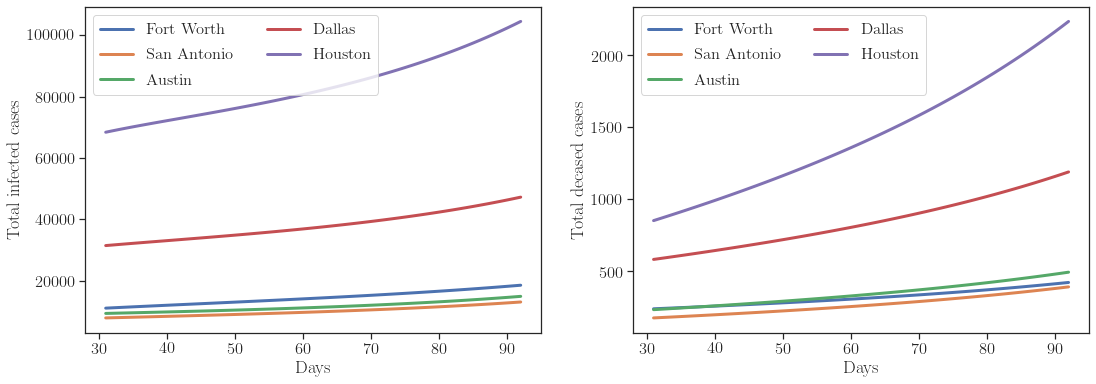

In [284]:
fig, ax = plt.subplots(ncols = 2, figsize = (18,6))
for col in range (2):
    for i in range(5):
        ax[col].plot(np.arange(92-30)+31, total_qoi_evolution[30:92, top_district[i], 0, col],\
                     label = district_names[top_district[i]], linewidth = 3)

        ax[col].set_xlabel(r"Days")
ax[0].set_ylabel(r"Total infected cases")
ax[1].set_ylabel(r"Total decased cases")
ax[0].legend(loc="upper left", ncol = 2, fancybox=True)
ax[1].legend(loc="upper left", ncol = 2, fancybox=True)


plt.savefig("prediction_top_five_district.pdf",bbox_inches = "tight")

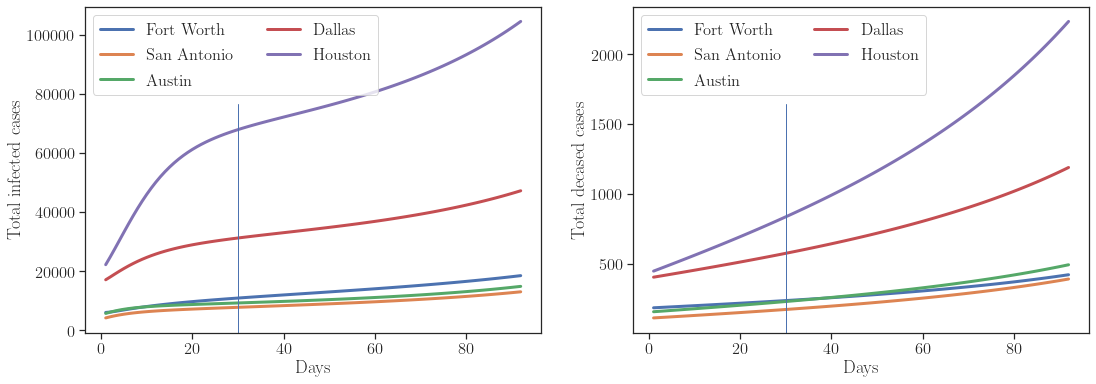

In [53]:
fig, ax = plt.subplots(ncols = 2, figsize = (18,6))
for col in range (2):
    for i in range(5):
        ax[col].plot(np.arange(92)+1, total_qoi_evolution[0:92, top_district[i], 0, col],\
                     label = district_names[top_district[i]], linewidth = 3)

        ax[col].set_xlabel(r"Days")


ax[0].axvline(x=30, ymax=0.7, linewidth=1)
ax[1].axvline(x=30, ymax=0.7, linewidth=1)
ax[0].set_ylabel(r"Total infected cases")
ax[1].set_ylabel(r"Total decased cases")
ax[0].legend(loc="upper left", ncol = 2, fancybox=True)
ax[1].legend(loc="upper left", ncol = 2, fancybox=True)


plt.savefig("prediction_top_five_district_vline.pdf",bbox_inches = "tight")